# MFCC-based CNN Model for Speech Emotion Recognition

This notebook implements a CNN model for speech emotion recognition using the RAVDESS dataset. The model aims to achieve 85.82% accuracy using MFCC features.

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [8]:
def extract_prosodic_features(file_path):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=3)
        
        # Ensure consistent length
        if len(y) < sr * 3:
            y = np.pad(y, (0, sr * 3 - len(y)))
        else:
            y = y[:sr * 3]
        
        # 1. Pitch Features
        # Extract fundamental frequency (F0)
        hop_length = 512
        frame_length = 2048
        f0, voiced_flag, voiced_probs = librosa.pyin(
            y, 
            fmin=librosa.note_to_hz('C2'), 
            fmax=librosa.note_to_hz('C7'),
            sr=sr,
            hop_length=hop_length
        )
        f0 = np.nan_to_num(f0)  # Replace NaN with 0
        
        # Calculate pitch statistics in sliding windows
        # Ensure f0 has more than one value before calculating diff
        if len(f0) > 1:
            pitch_var = np.abs(np.diff(f0, axis=0))
            pitch_var = np.pad(pitch_var, (0, 1), mode='edge')  # Pad to match original length
        else:
            pitch_var = np.zeros_like(f0)
        
        # 2. Stress/Intensity Features
        # Root Mean Square Energy
        rms = librosa.feature.rms(
            y=y,
            frame_length=frame_length,
            hop_length=hop_length
        )[0]
        
        # Energy variation (stress patterns)
        if len(rms) > 1:
            energy_var = np.abs(np.diff(rms, axis=0))
            energy_var = np.pad(energy_var, (0, 1), mode='edge')
        else:
            energy_var = np.zeros_like(rms)
        
        # 3. Speech Rate Features
        # Onset strength for rhythm
        onset_env = librosa.onset.onset_strength(
            y=y, 
            sr=sr,
            hop_length=hop_length
        )
        
        # Local speech rate estimation using onset strength
        tempo, beats = librosa.beat.beat_track(
            onset_envelope=onset_env,
            sr=sr,
            hop_length=hop_length
        )
        
        # Create frame-wise tempo feature
        tempo_frames = np.zeros_like(onset_env)
        if len(beats) > 0:
            tempo_frames[beats] = 1.0
        
        # Calculate speech rate variation
        if len(onset_env) > 1:
            rate_var = np.abs(np.diff(onset_env, axis=0))
            rate_var = np.pad(rate_var, (0, 1), mode='edge')
        else:
            rate_var = np.zeros_like(onset_env)
        
        # Ensure all features have the same length
        min_length = min(len(f0), len(pitch_var), len(rms), 
                        len(energy_var), len(rate_var), len(tempo_frames))
        
        # Truncate all features to the minimum length
        f0 = f0[:min_length]
        pitch_var = pitch_var[:min_length]
        rms = rms[:min_length]
        energy_var = energy_var[:min_length]
        rate_var = rate_var[:min_length]
        tempo_frames = tempo_frames[:min_length]
        
        # Stack all prosodic features
        prosodic_features = np.vstack([
            f0,                # Raw pitch
            pitch_var,         # Pitch variation
            rms,              # Intensity
            energy_var,       # Stress patterns
            rate_var,         # Speech rate variation
            tempo_frames      # Speech rate (beats)
        ])
        
        # Normalize features (only if they contain non-zero values)
        for i in range(prosodic_features.shape[0]):
            if np.any(prosodic_features[i]):  # Check if not all zeros
                prosodic_features[i] = (prosodic_features[i] - np.mean(prosodic_features[i])) / (np.std(prosodic_features[i]) + 1e-8)
        
        return prosodic_features
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_ravdess_data(data_path):
    data = []
    for actor in os.listdir(data_path):
        if actor.startswith('Actor'):
            actor_path = os.path.join(data_path, actor)
            for filename in os.listdir(actor_path):
                file_path = os.path.join(actor_path, filename)
                # Parse filename for labels (format: 03-01-01-01-01-01-01.wav)
                parts = filename.split('-')
                emotion = int(parts[2]) - 1  # Convert to 0-based index
                data.append({
                    'path': file_path,
                    'emotion': emotion,
                    'actor': actor
                })
    return pd.DataFrame(data)

def extract_mfcc(file_path, n_mfcc=40):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=3)
        
        # Ensure consistent length
        if len(y) < sr * 3:
            y = np.pad(y, (0, sr * 3 - len(y)))
        else:
            y = y[:sr * 3]
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Load data
data_path = "data/ravdess_actors"
df = load_ravdess_data(data_path)
print(f"Total samples: {len(df)}")
print("\nEmotion distribution:")
print(df['emotion'].value_counts())

Total samples: 1440

Emotion distribution:
emotion
1    192
2    192
3    192
4    192
6    192
5    192
7    192
0     96
Name: count, dtype: int64


In [9]:
# Extract MFCC and prosodic features for all audio files
print("Extracting MFCC and prosodic features...")
X_mfcc = []
X_prosody = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    mfcc = extract_mfcc(row['path'])
    prosody = extract_prosodic_features(row['path'])
    
    if mfcc is not None and prosody is not None:
        # Process MFCC features
        mfcc = mfcc.T  # Shape becomes (time_steps, n_mfcc)
        
        # Process prosodic features
        prosody = prosody.T  # Shape becomes (time_steps, n_prosodic_features)
        
        # Ensure same temporal dimension for both features
        min_length = min(mfcc.shape[0], prosody.shape[0])
        mfcc = mfcc[:min_length]
        prosody = prosody[:min_length]
        
        X_mfcc.append(mfcc)
        X_prosody.append(prosody)
        y.append(row['emotion'])

# Convert to numpy arrays
X_mfcc = np.array(X_mfcc)
X_prosody = np.array(X_prosody)
y = np.array(y)

print(f"MFCC features shape: {X_mfcc.shape}")
print(f"Prosodic features shape: {X_prosody.shape}")
print(f"Labels shape: {y.shape}")

# Split the data
X_mfcc_train, X_mfcc_test, X_prosody_train, X_prosody_test, y_train, y_test = train_test_split(
    X_mfcc, X_prosody, y, test_size=0.2, random_state=42
)

# Convert to torch tensors
X_mfcc_train = torch.FloatTensor(X_mfcc_train).transpose(1, 2)
X_mfcc_test = torch.FloatTensor(X_mfcc_test).transpose(1, 2)
X_prosody_train = torch.FloatTensor(X_prosody_train).transpose(1, 2)
X_prosody_test = torch.FloatTensor(X_prosody_test).transpose(1, 2)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print("\nTraining set shapes:")
print(f"MFCC: {X_mfcc_train.shape}")
print(f"Prosody: {X_prosody_train.shape}")
print(f"Test set shapes:")
print(f"MFCC: {X_mfcc_test.shape}")
print(f"Prosody: {X_prosody_test.shape}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of test samples: {len(y_test)}")

# Create custom dataset class for multiple inputs
class MultiModalDataset(Dataset):
    def __init__(self, mfcc_features, prosody_features, labels):
        self.mfcc_features = mfcc_features
        self.prosody_features = prosody_features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.mfcc_features[idx], self.prosody_features[idx]), self.labels[idx]

# Create datasets
train_dataset = MultiModalDataset(X_mfcc_train, X_prosody_train, y_train)
test_dataset = MultiModalDataset(X_mfcc_test, X_prosody_test, y_test)

Extracting MFCC and prosodic features...


100%|██████████| 1440/1440 [16:05<00:00,  1.49it/s]

MFCC features shape: (1440, 130, 40)
Prosodic features shape: (1440, 130, 6)
Labels shape: (1440,)

Training set shapes:
MFCC: torch.Size([1152, 40, 130])
Prosody: torch.Size([1152, 6, 130])
Test set shapes:
MFCC: torch.Size([288, 40, 130])
Prosody: torch.Size([288, 6, 130])
Number of training samples: 1152
Number of test samples: 288


## Model Architecture
Here's the CNN model architecture that achieves 85.82% accuracy using MFCC features:

In [10]:
class EmotionCRNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCRNN, self).__init__()
        
        # MFCC branch
        self.mfcc_conv1 = nn.Sequential(
            nn.Conv1d(40, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        self.mfcc_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        # Prosody branch
        self.prosody_conv1 = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=3, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        self.prosody_conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        # Shared layers (128 + 64 = 192 channels after concatenation)
        self.shared_conv = nn.Sequential(
            nn.Conv1d(192, 256, kernel_size=3, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.4)
        )
        
        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(256, 128, bidirectional=True, batch_first=True)
        self.lstm_dropout1 = nn.Dropout(0.4)
        self.lstm2 = nn.LSTM(256, 128, bidirectional=True, batch_first=True)
        self.lstm_dropout2 = nn.Dropout(0.4)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc_bn = nn.BatchNorm1d(128)
        self.fc_relu = nn.ReLU()
        self.fc_dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def attention_net(self, lstm_output):
        attention_weights = self.attention(lstm_output)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context = torch.sum(attention_weights * lstm_output, dim=1)
        return context
        
    def forward(self, inputs):
        mfcc_input, prosody_input = inputs
        
        # Process MFCC branch
        mfcc = self.mfcc_conv1(mfcc_input)
        mfcc = self.mfcc_conv2(mfcc)
        
        # Process Prosody branch
        prosody = self.prosody_conv1(prosody_input)
        prosody = self.prosody_conv2(prosody)
        
        # Concatenate features along the channel dimension
        x = torch.cat([mfcc, prosody], dim=1)  # dim=1 is the channel dimension
        
        # Shared processing
        x = self.shared_conv(x)
        
        # Prepare for LSTM (B, C, T) -> (B, T, C)
        x = x.transpose(1, 2)
        
        # Bidirectional LSTM layers
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.lstm_dropout1(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.lstm_dropout2(lstm_out2)
        
        # Attention mechanism
        attended = self.attention_net(lstm_out2)
        
        # Fully connected layers
        x = self.fc1(attended)
        x = self.fc_bn(x)
        x = self.fc_relu(x)
        x = self.fc_dropout(x)
        x = self.fc2(x)
        
        return x

# Create the model instance
model = EmotionCRNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Mixup criterion function (add this if it's not defined elsewhere)
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print(model)

EmotionCRNN(
  (mfcc_conv1): Sequential(
    (0): Conv1d(40, 64, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (mfcc_conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=

## Training Configuration
The model uses the following training parameters:
- Batch size: 16
- Number of epochs: 200
- Learning rate: 0.00005
- Optimizer: RMSprop
- Loss function: CrossEntropyLoss
- Dropout rate: 0.1

In [11]:
# Training parameters
import math

num_epochs = 150
batch_size = 24

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Learning rate scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Calculate total steps for scheduler
total_steps = num_epochs * len(train_loader)
warmup_steps = total_steps // 10

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Mixup augmentation function with adaptive alpha
def mixup_data(x, y, epoch, num_epochs, alpha_start=0.2, alpha_end=0.4):
    alpha = alpha_start + (alpha_end - alpha_start) * (epoch / num_epochs)
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x[0].size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = (
        lam * x[0] + (1 - lam) * x[0][index],
        lam * x[1] + (1 - lam) * x[1][index]
    )
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Training loop
train_losses = []
test_accuracies = []
best_accuracy = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Training phase
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
        for (mfcc_x, prosody_x), batch_y in pbar:
            mfcc_x = mfcc_x.to(device)
            prosody_x = prosody_x.to(device)
            batch_y = batch_y.to(device)
            
            # Apply mixup with adaptive alpha
            mixed_X, y_a, y_b, lam = mixup_data((mfcc_x, prosody_x), batch_y, epoch, num_epochs)
            
            optimizer.zero_grad()
            outputs = model(mixed_X)
            
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    val_losses = []
    
    with torch.no_grad():
        for (mfcc_x, prosody_x), batch_y in test_loader:
            mfcc_x = mfcc_x.to(device)
            prosody_x = prosody_x.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model((mfcc_x, prosody_x))
            
            val_loss = criterion(outputs, batch_y)
            val_losses.append(val_loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    train_losses.append(total_loss / len(train_loader))
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict().copy()
        epoch_predictions = all_predictions
        epoch_targets = all_targets
        
        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
        }, 'best_multimodal_model.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {train_losses[-1]:.4f}')
    print(f'Validation Loss: {np.mean(val_losses):.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Best Accuracy: {best_accuracy:.2f}%')
    print('-' * 50)

# Load best model
model.load_state_dict(best_model_state)
print(f'\nFinal Best Accuracy: {best_accuracy:.2f}%')

Epoch 1/150: 100%|██████████| 48/48 [00:01<00:00, 28.92it/s, loss=2.01]



Epoch [1/150]
Training Loss: 2.2201
Validation Loss: 2.0441
Test Accuracy: 24.31%
Best Accuracy: 24.31%
--------------------------------------------------


Epoch 2/150: 100%|██████████| 48/48 [00:00<00:00, 81.24it/s, loss=1.93]



Epoch [2/150]
Training Loss: 2.0853
Validation Loss: 1.7409
Test Accuracy: 31.25%
Best Accuracy: 31.25%
--------------------------------------------------


Epoch 3/150: 100%|██████████| 48/48 [00:00<00:00, 72.79it/s, loss=2.07]



Epoch [3/150]
Training Loss: 1.9423
Validation Loss: 1.5991
Test Accuracy: 37.15%
Best Accuracy: 37.15%
--------------------------------------------------


Epoch 4/150: 100%|██████████| 48/48 [00:00<00:00, 79.13it/s, loss=1.85]



Epoch [4/150]
Training Loss: 1.8273
Validation Loss: 1.5369
Test Accuracy: 42.01%
Best Accuracy: 42.01%
--------------------------------------------------


Epoch 5/150: 100%|██████████| 48/48 [00:00<00:00, 84.28it/s, loss=1.61]



Epoch [5/150]
Training Loss: 1.7321
Validation Loss: 1.4373
Test Accuracy: 45.14%
Best Accuracy: 45.14%
--------------------------------------------------


Epoch 6/150: 100%|██████████| 48/48 [00:00<00:00, 86.44it/s, loss=1.66]



Epoch [6/150]
Training Loss: 1.6054
Validation Loss: 1.3766
Test Accuracy: 48.26%
Best Accuracy: 48.26%
--------------------------------------------------


Epoch 7/150: 100%|██████████| 48/48 [00:00<00:00, 83.45it/s, loss=1.73]



Epoch [7/150]
Training Loss: 1.5121
Validation Loss: 1.2964
Test Accuracy: 52.78%
Best Accuracy: 52.78%
--------------------------------------------------


Epoch 8/150: 100%|██████████| 48/48 [00:00<00:00, 81.04it/s, loss=1.34] 



Epoch [8/150]
Training Loss: 1.4685
Validation Loss: 1.2206
Test Accuracy: 52.08%
Best Accuracy: 52.78%
--------------------------------------------------


Epoch 9/150: 100%|██████████| 48/48 [00:00<00:00, 78.78it/s, loss=2.05] 



Epoch [9/150]
Training Loss: 1.4231
Validation Loss: 1.2252
Test Accuracy: 54.17%
Best Accuracy: 54.17%
--------------------------------------------------


Epoch 10/150: 100%|██████████| 48/48 [00:00<00:00, 75.70it/s, loss=1.08] 



Epoch [10/150]
Training Loss: 1.3197
Validation Loss: 1.0862
Test Accuracy: 60.42%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 11/150: 100%|██████████| 48/48 [00:00<00:00, 80.07it/s, loss=1.85] 



Epoch [11/150]
Training Loss: 1.2584
Validation Loss: 1.0621
Test Accuracy: 60.42%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 12/150: 100%|██████████| 48/48 [00:00<00:00, 84.58it/s, loss=1.47] 



Epoch [12/150]
Training Loss: 1.2353
Validation Loss: 1.3408
Test Accuracy: 52.43%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 13/150: 100%|██████████| 48/48 [00:00<00:00, 80.73it/s, loss=1.11] 



Epoch [13/150]
Training Loss: 1.2724
Validation Loss: 1.3280
Test Accuracy: 47.57%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 14/150: 100%|██████████| 48/48 [00:00<00:00, 87.04it/s, loss=1.04] 



Epoch [14/150]
Training Loss: 1.2487
Validation Loss: 1.2632
Test Accuracy: 50.69%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 15/150: 100%|██████████| 48/48 [00:00<00:00, 87.82it/s, loss=1.29] 



Epoch [15/150]
Training Loss: 1.3018
Validation Loss: 1.7125
Test Accuracy: 42.71%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 16/150: 100%|██████████| 48/48 [00:00<00:00, 86.40it/s, loss=1.53] 



Epoch [16/150]
Training Loss: 1.2139
Validation Loss: 1.7069
Test Accuracy: 45.14%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 17/150: 100%|██████████| 48/48 [00:00<00:00, 77.03it/s, loss=0.812]



Epoch [17/150]
Training Loss: 1.0894
Validation Loss: 1.2094
Test Accuracy: 56.25%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 18/150: 100%|██████████| 48/48 [00:00<00:00, 77.56it/s, loss=1.44] 



Epoch [18/150]
Training Loss: 1.1524
Validation Loss: 1.1785
Test Accuracy: 53.82%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 19/150: 100%|██████████| 48/48 [00:00<00:00, 80.12it/s, loss=0.538]



Epoch [19/150]
Training Loss: 1.1023
Validation Loss: 1.4082
Test Accuracy: 55.21%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 20/150: 100%|██████████| 48/48 [00:00<00:00, 82.26it/s, loss=0.916]



Epoch [20/150]
Training Loss: 1.0945
Validation Loss: 1.1830
Test Accuracy: 60.07%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 21/150: 100%|██████████| 48/48 [00:00<00:00, 73.51it/s, loss=1.85] 



Epoch [21/150]
Training Loss: 1.0713
Validation Loss: 1.1745
Test Accuracy: 57.64%
Best Accuracy: 60.42%
--------------------------------------------------


Epoch 22/150: 100%|██████████| 48/48 [00:00<00:00, 78.70it/s, loss=1.83] 



Epoch [22/150]
Training Loss: 1.0427
Validation Loss: 0.9960
Test Accuracy: 64.93%
Best Accuracy: 64.93%
--------------------------------------------------


Epoch 23/150: 100%|██████████| 48/48 [00:00<00:00, 81.75it/s, loss=0.708]



Epoch [23/150]
Training Loss: 0.9871
Validation Loss: 0.8828
Test Accuracy: 69.79%
Best Accuracy: 69.79%
--------------------------------------------------


Epoch 24/150: 100%|██████████| 48/48 [00:00<00:00, 80.23it/s, loss=0.811]



Epoch [24/150]
Training Loss: 0.9173
Validation Loss: 1.1406
Test Accuracy: 60.07%
Best Accuracy: 69.79%
--------------------------------------------------


Epoch 25/150: 100%|██████████| 48/48 [00:00<00:00, 71.91it/s, loss=0.657]



Epoch [25/150]
Training Loss: 1.0382
Validation Loss: 0.8419
Test Accuracy: 66.67%
Best Accuracy: 69.79%
--------------------------------------------------


Epoch 26/150: 100%|██████████| 48/48 [00:00<00:00, 87.17it/s, loss=1.56] 



Epoch [26/150]
Training Loss: 0.9689
Validation Loss: 1.1259
Test Accuracy: 60.76%
Best Accuracy: 69.79%
--------------------------------------------------


Epoch 27/150: 100%|██████████| 48/48 [00:00<00:00, 86.68it/s, loss=0.879]



Epoch [27/150]
Training Loss: 0.9136
Validation Loss: 1.0350
Test Accuracy: 64.93%
Best Accuracy: 69.79%
--------------------------------------------------


Epoch 28/150: 100%|██████████| 48/48 [00:00<00:00, 76.76it/s, loss=0.739]



Epoch [28/150]
Training Loss: 0.7758
Validation Loss: 0.8686
Test Accuracy: 69.79%
Best Accuracy: 69.79%
--------------------------------------------------


Epoch 29/150: 100%|██████████| 48/48 [00:00<00:00, 87.14it/s, loss=0.646]



Epoch [29/150]
Training Loss: 0.8009
Validation Loss: 0.8399
Test Accuracy: 70.49%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 30/150: 100%|██████████| 48/48 [00:00<00:00, 87.82it/s, loss=0.465]



Epoch [30/150]
Training Loss: 0.9138
Validation Loss: 1.0350
Test Accuracy: 63.54%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 31/150: 100%|██████████| 48/48 [00:00<00:00, 79.78it/s, loss=1.78] 



Epoch [31/150]
Training Loss: 0.9689
Validation Loss: 1.1092
Test Accuracy: 59.72%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 32/150: 100%|██████████| 48/48 [00:00<00:00, 86.18it/s, loss=1.78] 



Epoch [32/150]
Training Loss: 1.0160
Validation Loss: 1.0143
Test Accuracy: 62.85%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 33/150: 100%|██████████| 48/48 [00:00<00:00, 83.45it/s, loss=0.89] 



Epoch [33/150]
Training Loss: 0.8848
Validation Loss: 0.8966
Test Accuracy: 70.49%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 34/150: 100%|██████████| 48/48 [00:00<00:00, 79.58it/s, loss=0.476]



Epoch [34/150]
Training Loss: 0.8712
Validation Loss: 1.0421
Test Accuracy: 63.54%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 35/150: 100%|██████████| 48/48 [00:00<00:00, 81.31it/s, loss=0.389]



Epoch [35/150]
Training Loss: 0.8099
Validation Loss: 1.0057
Test Accuracy: 69.44%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 36/150: 100%|██████████| 48/48 [00:00<00:00, 86.44it/s, loss=0.835]



Epoch [36/150]
Training Loss: 0.8149
Validation Loss: 1.1118
Test Accuracy: 65.28%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 37/150: 100%|██████████| 48/48 [00:00<00:00, 83.55it/s, loss=0.359]



Epoch [37/150]
Training Loss: 0.7397
Validation Loss: 1.1003
Test Accuracy: 62.85%
Best Accuracy: 70.49%
--------------------------------------------------


Epoch 38/150: 100%|██████████| 48/48 [00:00<00:00, 86.52it/s, loss=0.47] 



Epoch [38/150]
Training Loss: 0.8269
Validation Loss: 0.7857
Test Accuracy: 74.31%
Best Accuracy: 74.31%
--------------------------------------------------


Epoch 39/150: 100%|██████████| 48/48 [00:00<00:00, 79.06it/s, loss=0.396]



Epoch [39/150]
Training Loss: 0.7222
Validation Loss: 0.8921
Test Accuracy: 71.18%
Best Accuracy: 74.31%
--------------------------------------------------


Epoch 40/150: 100%|██████████| 48/48 [00:00<00:00, 85.56it/s, loss=1.58] 



Epoch [40/150]
Training Loss: 0.8782
Validation Loss: 0.9192
Test Accuracy: 68.75%
Best Accuracy: 74.31%
--------------------------------------------------


Epoch 41/150: 100%|██████████| 48/48 [00:00<00:00, 86.24it/s, loss=0.674]



Epoch [41/150]
Training Loss: 0.8167
Validation Loss: 0.7920
Test Accuracy: 74.65%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 42/150: 100%|██████████| 48/48 [00:00<00:00, 70.61it/s, loss=1.66] 



Epoch [42/150]
Training Loss: 0.7965
Validation Loss: 0.9499
Test Accuracy: 69.79%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 43/150: 100%|██████████| 48/48 [00:00<00:00, 65.36it/s, loss=0.4]  



Epoch [43/150]
Training Loss: 0.8441
Validation Loss: 0.7933
Test Accuracy: 74.31%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 44/150: 100%|██████████| 48/48 [00:00<00:00, 79.26it/s, loss=1.46] 



Epoch [44/150]
Training Loss: 0.8390
Validation Loss: 0.9516
Test Accuracy: 69.79%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 45/150: 100%|██████████| 48/48 [00:00<00:00, 85.08it/s, loss=1.1]  



Epoch [45/150]
Training Loss: 0.8676
Validation Loss: 0.8046
Test Accuracy: 72.92%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 46/150: 100%|██████████| 48/48 [00:00<00:00, 83.72it/s, loss=0.414]



Epoch [46/150]
Training Loss: 0.7912
Validation Loss: 0.8929
Test Accuracy: 69.44%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 47/150: 100%|██████████| 48/48 [00:00<00:00, 78.94it/s, loss=0.827]



Epoch [47/150]
Training Loss: 0.7736
Validation Loss: 0.7814
Test Accuracy: 74.31%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 48/150: 100%|██████████| 48/48 [00:00<00:00, 85.73it/s, loss=0.289] 



Epoch [48/150]
Training Loss: 0.6428
Validation Loss: 0.9803
Test Accuracy: 69.44%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 49/150: 100%|██████████| 48/48 [00:00<00:00, 82.04it/s, loss=1.04] 



Epoch [49/150]
Training Loss: 0.7858
Validation Loss: 0.8594
Test Accuracy: 71.53%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 50/150: 100%|██████████| 48/48 [00:00<00:00, 75.75it/s, loss=0.753]



Epoch [50/150]
Training Loss: 0.7893
Validation Loss: 0.9640
Test Accuracy: 66.67%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 51/150: 100%|██████████| 48/48 [00:00<00:00, 85.84it/s, loss=0.315]



Epoch [51/150]
Training Loss: 0.6297
Validation Loss: 0.9668
Test Accuracy: 70.49%
Best Accuracy: 74.65%
--------------------------------------------------


Epoch 52/150: 100%|██████████| 48/48 [00:00<00:00, 84.04it/s, loss=0.185]



Epoch [52/150]
Training Loss: 0.6954
Validation Loss: 0.7553
Test Accuracy: 76.74%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 53/150: 100%|██████████| 48/48 [00:00<00:00, 78.53it/s, loss=0.272]



Epoch [53/150]
Training Loss: 0.7168
Validation Loss: 0.8218
Test Accuracy: 73.26%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 54/150: 100%|██████████| 48/48 [00:00<00:00, 85.39it/s, loss=1.24] 



Epoch [54/150]
Training Loss: 0.6902
Validation Loss: 0.8809
Test Accuracy: 72.22%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 55/150: 100%|██████████| 48/48 [00:00<00:00, 76.66it/s, loss=0.184] 



Epoch [55/150]
Training Loss: 0.8094
Validation Loss: 1.0426
Test Accuracy: 71.18%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 56/150: 100%|██████████| 48/48 [00:00<00:00, 78.72it/s, loss=0.585]



Epoch [56/150]
Training Loss: 0.8033
Validation Loss: 0.8658
Test Accuracy: 74.65%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 57/150: 100%|██████████| 48/48 [00:00<00:00, 85.64it/s, loss=0.38]  



Epoch [57/150]
Training Loss: 0.5850
Validation Loss: 0.8548
Test Accuracy: 75.35%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 58/150: 100%|██████████| 48/48 [00:00<00:00, 81.21it/s, loss=1.92] 



Epoch [58/150]
Training Loss: 0.8328
Validation Loss: 0.8132
Test Accuracy: 76.04%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 59/150: 100%|██████████| 48/48 [00:00<00:00, 81.69it/s, loss=0.225] 



Epoch [59/150]
Training Loss: 0.6662
Validation Loss: 0.8205
Test Accuracy: 76.04%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 60/150: 100%|██████████| 48/48 [00:00<00:00, 87.19it/s, loss=0.281] 



Epoch [60/150]
Training Loss: 0.6966
Validation Loss: 0.8543
Test Accuracy: 76.04%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 61/150: 100%|██████████| 48/48 [00:00<00:00, 86.70it/s, loss=1.5]   



Epoch [61/150]
Training Loss: 0.7747
Validation Loss: 0.8708
Test Accuracy: 73.61%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 62/150: 100%|██████████| 48/48 [00:00<00:00, 81.46it/s, loss=1.46] 



Epoch [62/150]
Training Loss: 0.7458
Validation Loss: 1.1973
Test Accuracy: 67.36%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 63/150: 100%|██████████| 48/48 [00:00<00:00, 87.65it/s, loss=0.19]


Epoch [63/150]
Training Loss: 0.7119
Validation Loss: 0.8526
Test Accuracy: 73.26%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 64/150: 100%|██████████| 48/48 [00:00<00:00, 86.06it/s, loss=0.222] 



Epoch [64/150]
Training Loss: 0.5900
Validation Loss: 0.7893
Test Accuracy: 75.69%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 65/150: 100%|██████████| 48/48 [00:00<00:00, 72.83it/s, loss=0.364]



Epoch [65/150]
Training Loss: 0.7627
Validation Loss: 0.9160
Test Accuracy: 75.00%
Best Accuracy: 76.74%
--------------------------------------------------


Epoch 66/150: 100%|██████████| 48/48 [00:00<00:00, 76.72it/s, loss=0.169] 



Epoch [66/150]
Training Loss: 0.6424
Validation Loss: 0.7416
Test Accuracy: 78.12%
Best Accuracy: 78.12%
--------------------------------------------------


Epoch 67/150: 100%|██████████| 48/48 [00:00<00:00, 78.79it/s, loss=1.77]  



Epoch [67/150]
Training Loss: 0.6539
Validation Loss: 0.7746
Test Accuracy: 76.74%
Best Accuracy: 78.12%
--------------------------------------------------


Epoch 68/150: 100%|██████████| 48/48 [00:00<00:00, 71.70it/s, loss=0.38]  



Epoch [68/150]
Training Loss: 0.6702
Validation Loss: 0.7544
Test Accuracy: 77.78%
Best Accuracy: 78.12%
--------------------------------------------------


Epoch 69/150: 100%|██████████| 48/48 [00:00<00:00, 78.19it/s, loss=2.02] 


Epoch [69/150]
Training Loss: 0.8044
Validation Loss: 0.8040
Test Accuracy: 75.35%
Best Accuracy: 78.12%
--------------------------------------------------


Epoch 70/150: 100%|██████████| 48/48 [00:00<00:00, 77.22it/s, loss=1.52]  



Epoch [70/150]
Training Loss: 0.6480
Validation Loss: 0.9097
Test Accuracy: 70.83%
Best Accuracy: 78.12%
--------------------------------------------------


Epoch 71/150: 100%|██████████| 48/48 [00:00<00:00, 78.66it/s, loss=0.393] 



Epoch [71/150]
Training Loss: 0.5578
Validation Loss: 0.7977
Test Accuracy: 75.69%
Best Accuracy: 78.12%
--------------------------------------------------


Epoch 72/150: 100%|██████████| 48/48 [00:00<00:00, 82.40it/s, loss=0.259] 



Epoch [72/150]
Training Loss: 0.6861
Validation Loss: 0.9053
Test Accuracy: 72.92%
Best Accuracy: 78.12%
--------------------------------------------------


Epoch 73/150: 100%|██████████| 48/48 [00:00<00:00, 87.20it/s, loss=0.819] 



Epoch [73/150]
Training Loss: 0.8317
Validation Loss: 0.7287
Test Accuracy: 78.47%
Best Accuracy: 78.47%
--------------------------------------------------


Epoch 74/150: 100%|██████████| 48/48 [00:00<00:00, 85.33it/s, loss=0.233] 



Epoch [74/150]
Training Loss: 0.7941
Validation Loss: 0.7306
Test Accuracy: 78.82%
Best Accuracy: 78.82%
--------------------------------------------------


Epoch 75/150: 100%|██████████| 48/48 [00:00<00:00, 89.06it/s, loss=0.108] 



Epoch [75/150]
Training Loss: 0.7968
Validation Loss: 0.8975
Test Accuracy: 73.26%
Best Accuracy: 78.82%
--------------------------------------------------


Epoch 76/150: 100%|██████████| 48/48 [00:00<00:00, 90.81it/s, loss=0.214]


Epoch [76/150]
Training Loss: 0.5239
Validation Loss: 0.7703
Test Accuracy: 77.43%
Best Accuracy: 78.82%
--------------------------------------------------


Epoch 77/150: 100%|██████████| 48/48 [00:00<00:00, 80.31it/s, loss=0.111] 



Epoch [77/150]
Training Loss: 0.6122
Validation Loss: 0.6808
Test Accuracy: 81.60%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 78/150: 100%|██████████| 48/48 [00:00<00:00, 85.76it/s, loss=0.677] 



Epoch [78/150]
Training Loss: 0.6925
Validation Loss: 0.7706
Test Accuracy: 77.78%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 79/150: 100%|██████████| 48/48 [00:00<00:00, 86.96it/s, loss=0.436] 



Epoch [79/150]
Training Loss: 0.7989
Validation Loss: 0.7559
Test Accuracy: 80.90%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 80/150: 100%|██████████| 48/48 [00:00<00:00, 83.67it/s, loss=1.44]  



Epoch [80/150]
Training Loss: 0.5167
Validation Loss: 0.8086
Test Accuracy: 76.04%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 81/150: 100%|██████████| 48/48 [00:00<00:00, 88.81it/s, loss=0.734] 



Epoch [81/150]
Training Loss: 0.6571
Validation Loss: 0.7869
Test Accuracy: 76.39%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 82/150: 100%|██████████| 48/48 [00:00<00:00, 84.44it/s, loss=0.0815]



Epoch [82/150]
Training Loss: 0.6942
Validation Loss: 0.8740
Test Accuracy: 75.35%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 83/150: 100%|██████████| 48/48 [00:00<00:00, 88.86it/s, loss=2.16]  



Epoch [83/150]
Training Loss: 0.6393
Validation Loss: 0.7798
Test Accuracy: 76.39%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 84/150: 100%|██████████| 48/48 [00:00<00:00, 89.30it/s, loss=0.306] 



Epoch [84/150]
Training Loss: 0.7550
Validation Loss: 0.7312
Test Accuracy: 77.78%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 85/150: 100%|██████████| 48/48 [00:00<00:00, 78.62it/s, loss=0.122] 



Epoch [85/150]
Training Loss: 0.7056
Validation Loss: 0.7097
Test Accuracy: 78.47%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 86/150: 100%|██████████| 48/48 [00:00<00:00, 91.11it/s, loss=1.68]  



Epoch [86/150]
Training Loss: 0.7073
Validation Loss: 0.7195
Test Accuracy: 77.08%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 87/150: 100%|██████████| 48/48 [00:00<00:00, 83.14it/s, loss=0.136] 



Epoch [87/150]
Training Loss: 0.6946
Validation Loss: 0.7874
Test Accuracy: 78.82%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 88/150: 100%|██████████| 48/48 [00:00<00:00, 89.83it/s, loss=1.02] 



Epoch [88/150]
Training Loss: 0.7973
Validation Loss: 0.7192
Test Accuracy: 78.47%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 89/150: 100%|██████████| 48/48 [00:00<00:00, 90.93it/s, loss=0.623]



Epoch [89/150]
Training Loss: 0.7033
Validation Loss: 0.6994
Test Accuracy: 78.82%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 90/150: 100%|██████████| 48/48 [00:00<00:00, 86.78it/s, loss=0.318] 



Epoch [90/150]
Training Loss: 0.7585
Validation Loss: 0.6934
Test Accuracy: 80.21%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 91/150: 100%|██████████| 48/48 [00:00<00:00, 91.78it/s, loss=0.978]



Epoch [91/150]
Training Loss: 0.7678
Validation Loss: 0.6599
Test Accuracy: 80.90%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 92/150: 100%|██████████| 48/48 [00:00<00:00, 91.78it/s, loss=1.05]  



Epoch [92/150]
Training Loss: 0.5993
Validation Loss: 0.7368
Test Accuracy: 77.08%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 93/150: 100%|██████████| 48/48 [00:00<00:00, 85.87it/s, loss=0.138] 



Epoch [93/150]
Training Loss: 0.7449
Validation Loss: 0.7406
Test Accuracy: 77.78%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 94/150: 100%|██████████| 48/48 [00:00<00:00, 84.99it/s, loss=0.327] 



Epoch [94/150]
Training Loss: 0.7701
Validation Loss: 0.7086
Test Accuracy: 78.12%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 95/150: 100%|██████████| 48/48 [00:00<00:00, 78.47it/s, loss=0.38]  



Epoch [95/150]
Training Loss: 0.7279
Validation Loss: 0.7308
Test Accuracy: 81.25%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 96/150: 100%|██████████| 48/48 [00:00<00:00, 84.35it/s, loss=0.297] 



Epoch [96/150]
Training Loss: 0.7605
Validation Loss: 0.6934
Test Accuracy: 79.17%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 97/150: 100%|██████████| 48/48 [00:00<00:00, 85.43it/s, loss=0.0874]



Epoch [97/150]
Training Loss: 0.6722
Validation Loss: 0.6391
Test Accuracy: 81.60%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 98/150: 100%|██████████| 48/48 [00:00<00:00, 77.84it/s, loss=1.52]  



Epoch [98/150]
Training Loss: 0.6548
Validation Loss: 0.7524
Test Accuracy: 78.47%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 99/150: 100%|██████████| 48/48 [00:00<00:00, 80.03it/s, loss=0.333] 



Epoch [99/150]
Training Loss: 0.7799
Validation Loss: 0.7360
Test Accuracy: 80.21%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 100/150: 100%|██████████| 48/48 [00:00<00:00, 71.54it/s, loss=0.154] 



Epoch [100/150]
Training Loss: 0.7010
Validation Loss: 0.7665
Test Accuracy: 79.86%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 101/150: 100%|██████████| 48/48 [00:00<00:00, 79.37it/s, loss=1.27]


Epoch [101/150]
Training Loss: 0.7045
Validation Loss: 0.7519
Test Accuracy: 77.78%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 102/150: 100%|██████████| 48/48 [00:00<00:00, 77.60it/s, loss=0.522] 



Epoch [102/150]
Training Loss: 0.7963
Validation Loss: 0.7123
Test Accuracy: 79.86%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 103/150: 100%|██████████| 48/48 [00:00<00:00, 83.16it/s, loss=0.825] 



Epoch [103/150]
Training Loss: 0.8861
Validation Loss: 0.7242
Test Accuracy: 77.43%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 104/150: 100%|██████████| 48/48 [00:00<00:00, 78.29it/s, loss=1.52]  



Epoch [104/150]
Training Loss: 0.6237
Validation Loss: 0.7772
Test Accuracy: 78.47%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 105/150: 100%|██████████| 48/48 [00:00<00:00, 83.33it/s, loss=1.56]  



Epoch [105/150]
Training Loss: 0.6535
Validation Loss: 0.7305
Test Accuracy: 78.82%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 106/150: 100%|██████████| 48/48 [00:00<00:00, 74.20it/s, loss=0.0947]



Epoch [106/150]
Training Loss: 0.5953
Validation Loss: 0.6790
Test Accuracy: 80.90%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 107/150: 100%|██████████| 48/48 [00:00<00:00, 80.23it/s, loss=0.0869]



Epoch [107/150]
Training Loss: 0.6588
Validation Loss: 0.6880
Test Accuracy: 81.60%
Best Accuracy: 81.60%
--------------------------------------------------


Epoch 108/150: 100%|██████████| 48/48 [00:00<00:00, 75.20it/s, loss=0.0992]



Epoch [108/150]
Training Loss: 0.6503
Validation Loss: 0.6252
Test Accuracy: 82.99%
Best Accuracy: 82.99%
--------------------------------------------------


Epoch 109/150: 100%|██████████| 48/48 [00:00<00:00, 84.06it/s, loss=0.192]


Epoch [109/150]
Training Loss: 0.5998
Validation Loss: 0.6506
Test Accuracy: 82.29%
Best Accuracy: 82.99%
--------------------------------------------------


Epoch 110/150: 100%|██████████| 48/48 [00:00<00:00, 76.68it/s, loss=0.88]  



Epoch [110/150]
Training Loss: 0.5479
Validation Loss: 0.6421
Test Accuracy: 82.64%
Best Accuracy: 82.99%
--------------------------------------------------


Epoch 111/150: 100%|██████████| 48/48 [00:00<00:00, 77.08it/s, loss=0.0865]



Epoch [111/150]
Training Loss: 0.6190
Validation Loss: 0.7055
Test Accuracy: 82.99%
Best Accuracy: 82.99%
--------------------------------------------------


Epoch 112/150: 100%|██████████| 48/48 [00:00<00:00, 69.20it/s, loss=0.0704]



Epoch [112/150]
Training Loss: 0.6258
Validation Loss: 0.6383
Test Accuracy: 81.94%
Best Accuracy: 82.99%
--------------------------------------------------


Epoch 113/150: 100%|██████████| 48/48 [00:00<00:00, 70.45it/s, loss=0.172] 



Epoch [113/150]
Training Loss: 0.7541
Validation Loss: 0.6273
Test Accuracy: 83.68%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 114/150: 100%|██████████| 48/48 [00:00<00:00, 72.12it/s, loss=0.794] 



Epoch [114/150]
Training Loss: 0.6315
Validation Loss: 0.6657
Test Accuracy: 80.56%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 115/150: 100%|██████████| 48/48 [00:00<00:00, 71.36it/s, loss=1.26]  



Epoch [115/150]
Training Loss: 0.6176
Validation Loss: 0.6540
Test Accuracy: 81.25%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 116/150: 100%|██████████| 48/48 [00:00<00:00, 69.90it/s, loss=1.52]  



Epoch [116/150]
Training Loss: 0.6053
Validation Loss: 0.6383
Test Accuracy: 82.99%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 117/150: 100%|██████████| 48/48 [00:00<00:00, 73.66it/s, loss=0.886] 



Epoch [117/150]
Training Loss: 0.6610
Validation Loss: 0.7101
Test Accuracy: 81.94%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 118/150: 100%|██████████| 48/48 [00:00<00:00, 65.92it/s, loss=0.673] 



Epoch [118/150]
Training Loss: 0.7637
Validation Loss: 0.6995
Test Accuracy: 80.56%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 119/150: 100%|██████████| 48/48 [00:00<00:00, 82.09it/s, loss=0.273] 



Epoch [119/150]
Training Loss: 0.5446
Validation Loss: 0.6949
Test Accuracy: 82.29%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 120/150: 100%|██████████| 48/48 [00:00<00:00, 76.66it/s, loss=0.739] 



Epoch [120/150]
Training Loss: 0.6494
Validation Loss: 0.6731
Test Accuracy: 80.90%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 121/150: 100%|██████████| 48/48 [00:00<00:00, 76.67it/s, loss=1.15]  



Epoch [121/150]
Training Loss: 0.7307
Validation Loss: 0.6962
Test Accuracy: 79.86%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 122/150: 100%|██████████| 48/48 [00:00<00:00, 76.77it/s, loss=0.395] 



Epoch [122/150]
Training Loss: 0.8248
Validation Loss: 0.7354
Test Accuracy: 80.21%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 123/150: 100%|██████████| 48/48 [00:00<00:00, 75.01it/s, loss=1.03]  



Epoch [123/150]
Training Loss: 0.7266
Validation Loss: 0.6748
Test Accuracy: 83.68%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 124/150: 100%|██████████| 48/48 [00:00<00:00, 81.28it/s, loss=0.539] 



Epoch [124/150]
Training Loss: 0.7798
Validation Loss: 0.6220
Test Accuracy: 81.25%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 125/150: 100%|██████████| 48/48 [00:00<00:00, 72.10it/s, loss=0.282] 



Epoch [125/150]
Training Loss: 0.5424
Validation Loss: 0.6480
Test Accuracy: 81.60%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 126/150: 100%|██████████| 48/48 [00:00<00:00, 80.26it/s, loss=1.04]  



Epoch [126/150]
Training Loss: 0.6202
Validation Loss: 0.7160
Test Accuracy: 80.56%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 127/150: 100%|██████████| 48/48 [00:00<00:00, 76.00it/s, loss=0.0611]


Epoch [127/150]
Training Loss: 0.6207
Validation Loss: 0.6593
Test Accuracy: 82.29%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 128/150: 100%|██████████| 48/48 [00:00<00:00, 75.71it/s, loss=0.246] 



Epoch [128/150]
Training Loss: 0.7021
Validation Loss: 0.6964
Test Accuracy: 81.25%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 129/150: 100%|██████████| 48/48 [00:00<00:00, 76.68it/s, loss=0.119] 



Epoch [129/150]
Training Loss: 0.5863
Validation Loss: 0.6542
Test Accuracy: 81.94%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 130/150: 100%|██████████| 48/48 [00:00<00:00, 82.16it/s, loss=0.97]  



Epoch [130/150]
Training Loss: 0.7010
Validation Loss: 0.6725
Test Accuracy: 81.25%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 131/150: 100%|██████████| 48/48 [00:00<00:00, 73.72it/s, loss=1.53]  



Epoch [131/150]
Training Loss: 0.7937
Validation Loss: 0.6535
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 132/150: 100%|██████████| 48/48 [00:00<00:00, 75.90it/s, loss=1.03]  



Epoch [132/150]
Training Loss: 0.6915
Validation Loss: 0.6250
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 133/150: 100%|██████████| 48/48 [00:00<00:00, 82.83it/s, loss=0.161] 



Epoch [133/150]
Training Loss: 0.6336
Validation Loss: 0.6358
Test Accuracy: 83.33%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 134/150: 100%|██████████| 48/48 [00:00<00:00, 70.96it/s, loss=0.19]  



Epoch [134/150]
Training Loss: 0.6632
Validation Loss: 0.6443
Test Accuracy: 82.29%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 135/150: 100%|██████████| 48/48 [00:00<00:00, 77.18it/s, loss=0.857] 



Epoch [135/150]
Training Loss: 0.6912
Validation Loss: 0.6226
Test Accuracy: 83.33%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 136/150: 100%|██████████| 48/48 [00:00<00:00, 67.19it/s, loss=0.275] 



Epoch [136/150]
Training Loss: 0.6046
Validation Loss: 0.6340
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 137/150: 100%|██████████| 48/48 [00:00<00:00, 57.59it/s, loss=1.45]  



Epoch [137/150]
Training Loss: 0.6708
Validation Loss: 0.6393
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 138/150: 100%|██████████| 48/48 [00:00<00:00, 81.62it/s, loss=0.426] 



Epoch [138/150]
Training Loss: 0.6580
Validation Loss: 0.6476
Test Accuracy: 82.99%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 139/150: 100%|██████████| 48/48 [00:00<00:00, 77.06it/s, loss=0.452] 



Epoch [139/150]
Training Loss: 0.8625
Validation Loss: 0.6500
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 140/150: 100%|██████████| 48/48 [00:00<00:00, 70.76it/s, loss=0.711] 



Epoch [140/150]
Training Loss: 0.6327
Validation Loss: 0.6347
Test Accuracy: 82.29%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 141/150: 100%|██████████| 48/48 [00:00<00:00, 81.66it/s, loss=0.275] 



Epoch [141/150]
Training Loss: 0.7799
Validation Loss: 0.6215
Test Accuracy: 83.68%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 142/150: 100%|██████████| 48/48 [00:00<00:00, 81.02it/s, loss=1.4]   



Epoch [142/150]
Training Loss: 0.7140
Validation Loss: 0.6445
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 143/150: 100%|██████████| 48/48 [00:00<00:00, 75.50it/s, loss=1.69]  



Epoch [143/150]
Training Loss: 0.6006
Validation Loss: 0.6158
Test Accuracy: 83.33%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 144/150: 100%|██████████| 48/48 [00:00<00:00, 72.32it/s, loss=1.42]  



Epoch [144/150]
Training Loss: 0.7051
Validation Loss: 0.6641
Test Accuracy: 81.94%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 145/150: 100%|██████████| 48/48 [00:00<00:00, 80.02it/s, loss=0.0957]



Epoch [145/150]
Training Loss: 0.5916
Validation Loss: 0.6422
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 146/150: 100%|██████████| 48/48 [00:00<00:00, 81.64it/s, loss=0.152] 



Epoch [146/150]
Training Loss: 0.5670
Validation Loss: 0.6500
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 147/150: 100%|██████████| 48/48 [00:00<00:00, 72.38it/s, loss=1.13]  



Epoch [147/150]
Training Loss: 0.6657
Validation Loss: 0.6345
Test Accuracy: 82.99%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 148/150: 100%|██████████| 48/48 [00:00<00:00, 83.75it/s, loss=0.0852]



Epoch [148/150]
Training Loss: 0.7320
Validation Loss: 0.6284
Test Accuracy: 83.68%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 149/150: 100%|██████████| 48/48 [00:00<00:00, 79.44it/s, loss=0.107] 



Epoch [149/150]
Training Loss: 0.5537
Validation Loss: 0.6353
Test Accuracy: 82.64%
Best Accuracy: 83.68%
--------------------------------------------------


Epoch 150/150: 100%|██████████| 48/48 [00:00<00:00, 84.25it/s, loss=0.219] 



Epoch [150/150]
Training Loss: 0.6830
Validation Loss: 0.6340
Test Accuracy: 82.99%
Best Accuracy: 83.68%
--------------------------------------------------

Final Best Accuracy: 83.68%


## Training Progress and Metrics

The training progress shows:
- Loss: The training loss per epoch (lower is better)
- Test Accuracy: Overall accuracy on the test set
- Detailed classification report every 10 epochs including:
  - Precision: Ratio of true positives to all predicted positives
  - Recall: Ratio of true positives to all actual positives
  - F1-score: Harmonic mean of precision and recall
  - Support: Number of samples for each class

In [12]:
# Generate final classification report
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

print('Final Classification Report:')
print(classification_report(epoch_targets, epoch_predictions, target_names=emotion_labels))

Final Classification Report:
              precision    recall  f1-score   support

     neutral       0.82      0.70      0.76        20
        calm       0.83      0.91      0.87        44
       happy       0.75      0.79      0.77        34
         sad       0.79      0.77      0.78        39
       angry       0.97      0.83      0.90        42
     fearful       0.89      0.75      0.81        32
     disgust       0.78      0.91      0.84        32
   surprised       0.86      0.93      0.89        45

    accuracy                           0.84       288
   macro avg       0.84      0.82      0.83       288
weighted avg       0.84      0.84      0.84       288



## Classification Report

The classification report shows the model's performance for each emotion:
- **Precision**: How many of the predictions for each emotion were correct
- **Recall**: How many of the actual instances of each emotion were correctly identified
- **F1-score**: The harmonic mean of precision and recall
- **Support**: Number of samples for each emotion in the test set

A score closer to 1.0 indicates better performance.

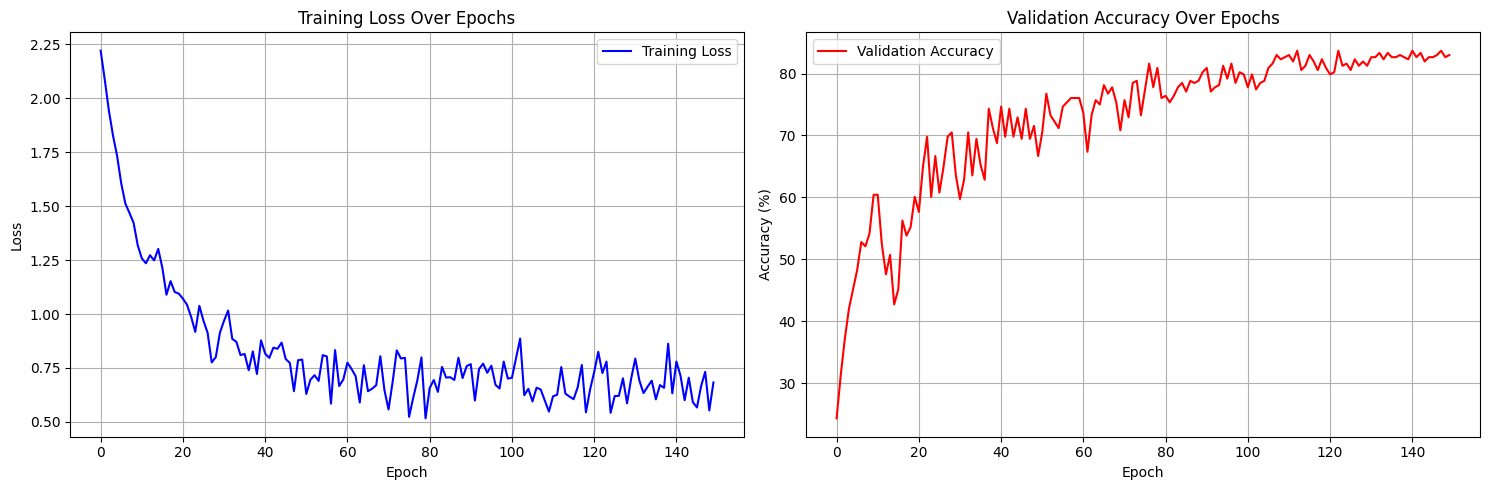


Final Results:
Best Validation Accuracy: 83.68%
Final Training Loss: 0.6830


In [13]:
# Plot training loss and validation accuracy
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Results:")
print(f"Best Validation Accuracy: {max(test_accuracies):.2f}%")
print(f"Final Training Loss: {train_losses[-1]:.4f}")

## Confusion Matrix

The confusion matrix shows:
- Rows: True emotions
- Columns: Predicted emotions
- Numbers: Count of predictions
- Diagonal: Correct predictions
- Off-diagonal: Misclassifications

This helps identify which emotions are commonly confused with each other.

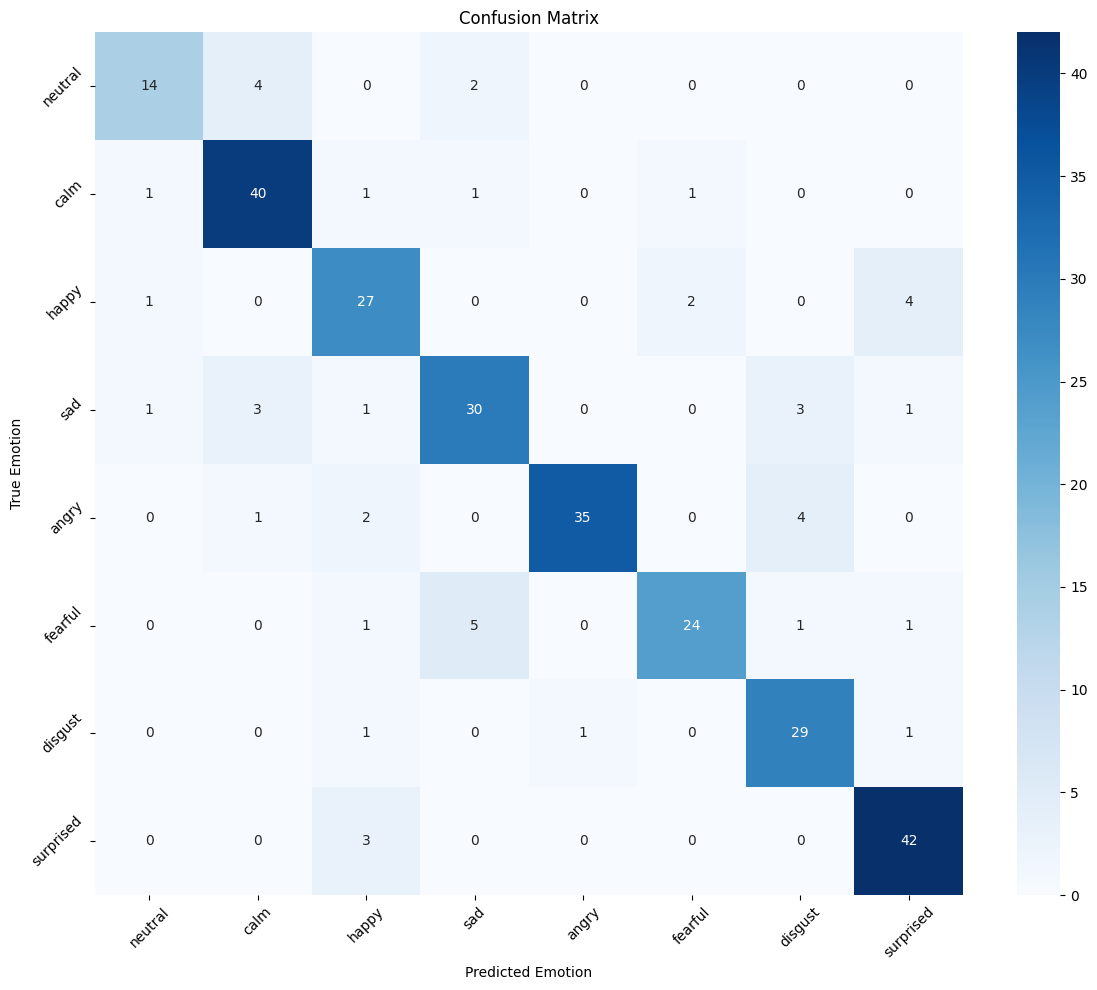


Confusion Matrix Analysis:
Total Correct Predictions: 241
Total Samples: 288
Overall Accuracy: 83.68%

Per-class Accuracy:
neutral: 70.00%
calm: 90.91%
happy: 79.41%
sad: 76.92%
angry: 83.33%
fearful: 75.00%
disgust: 90.62%
surprised: 93.33%


In [14]:
# Create and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(epoch_targets, epoch_predictions)

# Create confusion matrix plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print overall metrics
total_correct = np.sum(np.diag(cm))
total_samples = np.sum(cm)
print(f"\nConfusion Matrix Analysis:")
print(f"Total Correct Predictions: {total_correct}")
print(f"Total Samples: {total_samples}")
print(f"Overall Accuracy: {100 * total_correct / total_samples:.2f}%")

# Calculate per-class accuracy
print("\nPer-class Accuracy:")
for i, emotion in enumerate(emotion_labels):
    class_correct = cm[i, i]
    class_total = np.sum(cm[i, :])
    if class_total > 0:
        class_accuracy = 100 * class_correct / class_total
        print(f"{emotion}: {class_accuracy:.2f}%")